In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, roc_curve, balanced_accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
import numpy as np
from keras.layers import Dropout
from keras.layers import BatchNormalization
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
# Read the CSV file into a DataFrame
Data = pd.read_csv(r"C:\Users\daddy\Downloads\sunspot_data.csv\sunspot_data.csv")
Data = Data[Data["Number of Sunspots"] != -1]
# Reset the index after removing rows
Data.reset_index(drop=True, inplace=True)
# Create a new feature as the product of 'Standard Deviation' and 'Number of Sunspots'
Data['Interaction_Feature'] = Data['Standard Deviation'] * Data['Number of Sunspots']

# Create a quadratic feature from 'Standard Deviation'
quadratic = PolynomialFeatures(degree=2, include_bias=True)
quadratic_feature = quadratic.fit_transform(Data[['Standard Deviation']])
Data['Quadratic_Feature'] = quadratic_feature[:, 1]  # Select the quadratic term (x^2)

# Create a cubic feature from 'Standard Deviation'
cubic = PolynomialFeatures(degree=2, include_bias=True)
cubic_feature = cubic.fit_transform(Data[['Standard Deviation']])
Data['Cubic_Feature'] = cubic_feature[:, 2]

# Normalize the 'Standard Deviation' column
scaler = StandardScaler()
Data['Standard Deviation'] = scaler.fit_transform(Data[['Standard Deviation']])

# Create a feature matrix for the logistic regression and XGBoost classifier
X = Data[['Interaction_Feature']].values
y = (Data['Number of Sunspots'] >= 83).astype(int)  # Convert to binary labels: 1 for >= 83 sunspots, 0 otherwise

# Handling class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=200)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=200)

# Train a logistic regression model with adjusted hyperparameters
logistic_model = LogisticRegression(C=1.0, max_iter=1000)
logistic_model.fit(X_train, y_train)
# Predict using the logistic regression model and add the predictions as a new column
Data['LogisticRegression'] = logistic_model.predict(X)

# Train an XGBoost classifier with adjusted hyperparameters
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predict using the XGBoost classifier and add the predictions as a new column
Data['XGBoostClassifier'] = xgb_model.predict(X)

# Calculate the correlation matrix with the new features
correlation_matrix = Data.corr()
# Print the correlation matrix
print(correlation_matrix)

                          Unnamed: 0      Year     Month       Day  \
Unnamed: 0                  1.000000  0.999987  0.003660  0.003773   
Year                        0.999987  1.000000 -0.001386  0.003305   
Month                       0.003660 -0.001386  1.000000  0.008554   
Day                         0.003773  0.003305  0.008554  1.000000   
Date In Fraction Of Year    1.000000  0.999987  0.003660  0.003774   
Number of Sunspots          0.064322  0.064302  0.003905 -0.000028   
Standard Deviation         -0.292982 -0.293004  0.003890 -0.002414   
Observations                0.637633  0.637660 -0.005003  0.000263   
Indicator                  -0.071561 -0.071440 -0.024177 -0.000795   
Interaction_Feature        -0.097039 -0.097062  0.004196  0.001880   
Quadratic_Feature          -0.292982 -0.293004  0.003890 -0.002414   
Cubic_Feature              -0.291409 -0.291431  0.003513  0.000631   
LogisticRegression         -0.066576 -0.066581  0.001079 -0.003570   
XGBoostClassifier   

In [2]:
# Evaluate the performance of the logistic regression model
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, y_pred_logistic)

print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_logistic)
print("Precision:", precision_logistic)
print("Recall:", recall_logistic)
print("F1 Score:", f1_logistic)
print("ROC-AUC:", roc_auc_logistic)

# Evaluate the performance of the XGBoost classifier
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print("XGBoost Classifier Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)
print("ROC-AUC:", roc_auc_xgb)

Logistic Regression Metrics:
Accuracy: 0.9517057504696116
Precision: 0.9524499155201545
Recall: 0.951416515973478
F1 Score: 0.9519329352873771
ROC-AUC: 0.9517072833278696
XGBoost Classifier Metrics:
Accuracy: 0.984184693692056
Precision: 0.9884484435797666
Recall: 0.9799879445449066
F1 Score: 0.9842000121072705
ROC-AUC: 0.9842069352354164


In [ ]:
AS WE CAN SEE, BOTH THE LOGISTIC REGRESSION AND XG-BOOST CLASSIFIERS HAVE OVER 95% ACCURACY, PRECISION, RECALL, F1-SCORE AND RATE OF CHANGE OF THE AREA UNDER THE CURVE, 
WE ALSO SEE IN THE PREVIOUS SLIDE BEFORE THESE EVALUATION METRICS THAT BOTH THE LOGISTIC REGRESSION AND XG-BOOST CLASSIFIER MODEL FEATURES WE HAVE ENGINEERED ARE CORRELATED WITH THE NUMBER OF SUNSPOTS AT ABOVE AN 80% LEVEL

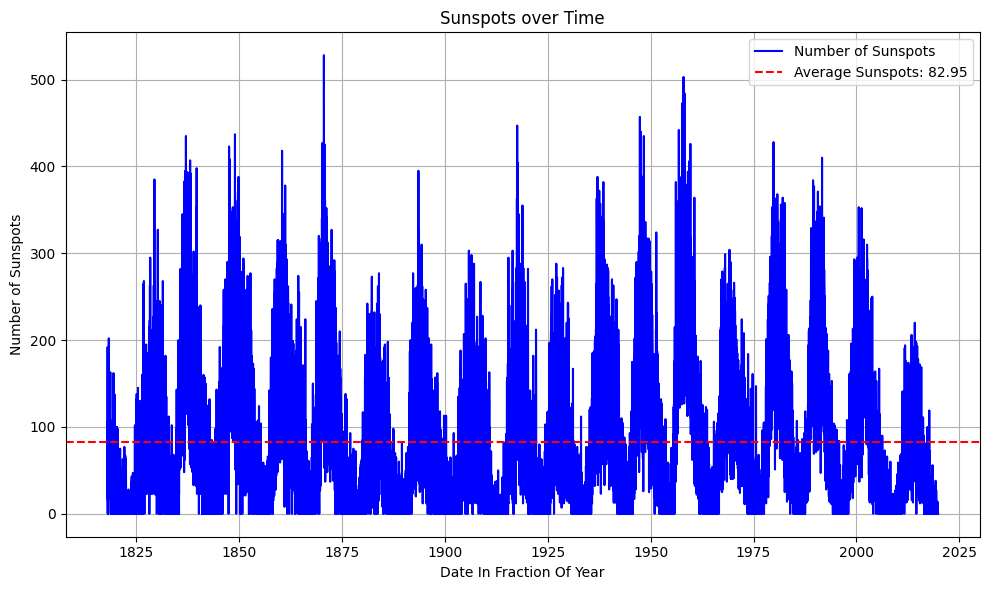

In [3]:
# Calculate the average number of sunspots
average_sunspots = Data['Number of Sunspots'].mean()
# Generate the line plot for the average number of sun spots
plt.figure(figsize=(10, 6))
plt.plot(Data['Date In Fraction Of Year'], Data['Number of Sunspots'], label='Number of Sunspots', color='blue')
plt.axhline(average_sunspots, color='red', linestyle='dashed', label=f'Average Sunspots: {average_sunspots:.2f}')
plt.xlabel('Date In Fraction Of Year')
plt.ylabel('Number of Sunspots')
plt.title('Sunspots over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/50
468/468 - 3s - loss: 4.3489 - accuracy: 0.5468 - val_loss: 2.3193 - val_accuracy: 0.5071 - 3s/epoch - 6ms/step
Epoch 2/50
468/468 - 1s - loss: 3.6270 - accuracy: 0.5951 - val_loss: 2.4379 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 3/50
468/468 - 1s - loss: 3.2491 - accuracy: 0.6182 - val_loss: 1.7581 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 4/50
468/468 - 1s - loss: 2.7484 - accuracy: 0.6402 - val_loss: 1.1455 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 5/50
468/468 - 1s - loss: 2.1615 - accuracy: 0.6644 - val_loss: 0.7043 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 6/50
468/468 - 1s - loss: 1.7906 - accuracy: 0.6831 - val_loss: 0.5821 - val_accuracy: 0.7609 - 1s/epoch - 2ms/step
Epoch 7/50
468/468 - 1s - loss: 1.4531 - accuracy: 0.7018 - val_loss: 0.4979 - val_accuracy: 0.8135 - 1s/epoch - 2ms/step
Epoch 8/50
468/468 - 1s - loss: 1.1492 - accuracy: 0.7229 - val_loss: 0.4400 - val_accuracy: 0.8601 - 1s/epoch - 2ms/step
Epoch 9/50
468/468 - 1s 

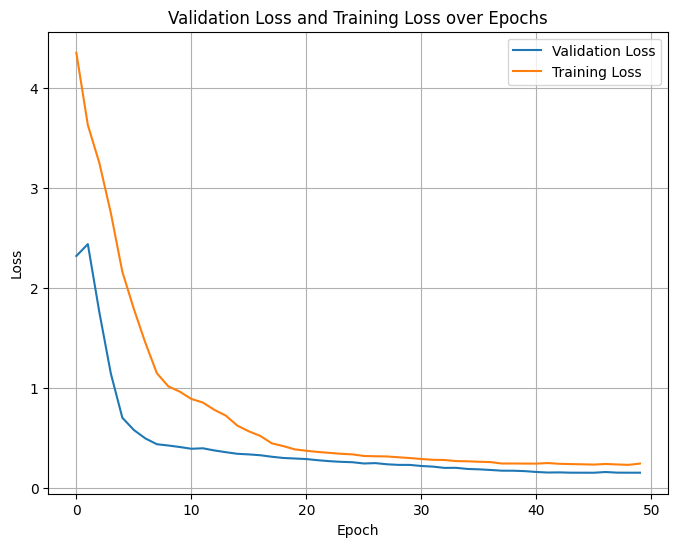

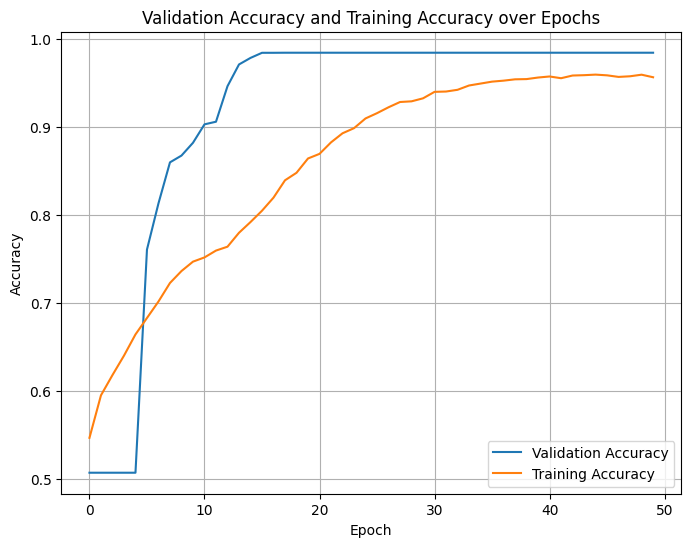

366/366 [==============================] - 0s 806us/step
AUC: 0.9971854551036862
Confusion Matrix:
 [[5894   32]
 [ 302 5458]]
Precision: 0.9724102629471711
F1 Score: 0.9713941197347759
Recall (Sensitivity): 0.971418791716584
Balanced Accuracy: 0.9710847559718003


In [4]:
# Create a feature matrix for the logistic regression and XGBoost classifier
X = Data[['LogisticRegression', 'XGBoostClassifier', 'Interaction_Feature']].values
y = (Data['Number of Sunspots'] >= 83).astype(int)  # MAKE THE TARGET ANYTHING GREATER THAN THE AVERAGE

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handling class imbalance using a combined approach of RandomUnderSampler + SMOTE
under_sampler = RandomUnderSampler(random_state=200)
X_undersampled, y_undersampled = under_sampler.fit_resample(X_scaled, y)

smote = SMOTE(random_state=200)
X_resampled, y_resampled = smote.fit_resample(X_undersampled, y_undersampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
# Build the Convolutional Neural Network model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.9))
cnn_model.add(Dense(1, activation='sigmoid')) 
cnn_model.add(BatchNormalization())
# Compile the model with the custom optimizer
custom_optimizer = Adam(learning_rate=0.00001)
cnn_model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

# Train the Convolutional Neural Network model with class weights
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), class_weight=class_weights, verbose=2)

# Extract training and validation logarithmic loss and accuracy from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot validation loss
plt.figure(figsize=(8, 6))
plt.plot(val_loss, label='Validation Loss')
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss and Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(train_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy and Training Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

# Predict using the Convolutional Neural Network model
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_classes = (y_pred_cnn > 0.8).astype(int)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_cnn)
print("AUC:", auc_score)
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_cnn_classes)
print("Confusion Matrix:\n", conf_matrix)

# Precision
precision = precision_score(y_test, y_pred_cnn_classes, average='weighted')
print("Precision:", precision)
# F1-score
f1 = f1_score(y_test, y_pred_cnn_classes, average='weighted')
print("F1 Score:", f1)
# Recall
recall = recall_score(y_test, y_pred_cnn_classes, average='weighted')
print("Recall (Sensitivity):", recall)
# Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_cnn_classes)
print("Balanced Accuracy:", balanced_accuracy)

AUC (Area Under the Receiver Operating Characteristic Curve) measures the models ability to distinguish between positive and negative samples.Our AUC value of 0.9971854551036862 indicates that the model has excellent discriminatory power, as it is very close to 1 right. An AUC of 1 represents a perfect model that comprehends the FULL variance of the data, while an AUC of 0.5 represents random guessing as it means the model essentially only comprehends half of what it sees. Which is of course no better than a human.

In the CONFUSION MATRIX we see 5894 samples were correctly predicted as positive (sunspots >= 83 or greater than the average).
while 5458 samples were correctly predicted as negative (sunspots < 83).
Additionally 32 samples were incorrectly predicted as positive and 302 samples were incorrectly predicted as negative.

Precision measures the proportion of correctly predicted positive samples (TP) out of all samples predicted as positive. A PRECISION score of 0.9724102629471711 indicates that the model has a high ability to avoid false positives, and it is good at accurately predicting positive samples. Meaning our model is VERY accurate in identifying when the number of sunspots will be GREATER than the average. 

F1 score is the harmonic mean of precision and recall (sensitivity). It provides a balance between precision and recall, especially when dealing with imbalanced datasets which THIS WAS HEAVILY IMBALANCED as we had to utilize under-sampling and SMOTE to balance our class weights.. An F1 score of 0.9713941197347759 is VERY high indicating a good trade-off between precision and recall. 

Recall measures the proportion of correctly predicted positive samples (TP) out of all actual positive samples.. An recall score of 0.971418791716584 indicates that the model is good at capturing the positive samples and has a high sensitivity. Sensitivity in the sense that the model is SPECIFIC. Some humans might interpret this as confidence. 

Balanced accuracy calculates the arithmetic mean of sensitivity (recall) and specificity. It provides a balanced view of the models performance on both positive and negative samples. The balanced accuracy of 0.9710847559718003 is high, which confirms the model's ability to perform well on both classes.

OVERALL the evaluation metrics suggest that the CNN model has HIGH discriminatory power, it avoids FALSE positives, it captures POSITIVE samples VERY WELL, and demonstrates a balanced performance on both classes. 


In [6]:
from keras.models import load_model
# Save the trained model to your desktop
model_save_path = "/path/to/your/desktop/SunSpotAverage_model.h5"
cnn_model.save(model_save_path)
print("Model saved to:", model_save_path)

Model saved to: /path/to/your/desktop/SunSpotAverage_model.h5
